In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpy

In [2]:
path = "/work/bm1235/k203123/nextgems_prefinal/experiments/ngc4008a/outdata/ngc4008a.yaml"
cat = intake.open_catalog(path)
ds_icon_inst = cat.ngc4008a(
    chunks="auto",  zoom=9, time='PT15M'
).to_dask()
ds_icon_inst_1 = ds_icon_inst.sel(time=slice('2021-07-01', '2021-07-07'))
ds_icon_inst_2 = ds_icon_inst.sel(time=slice('2033-07-01', '2033-07-07'))

/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
ds_icon_inst_1

<xarray.Dataset> Size: 8TB
Dimensions:     (time: 671, level_full: 90, cell: 3145728, crs: 1,
                 level_half: 91)
Coordinates:
  * crs         (crs) float32 4B nan
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
  * level_half  (level_half) int32 364B 1 2 3 4 5 6 7 8 ... 85 86 87 88 89 90 91
  * time        (time) datetime64[ns] 5kB 2021-07-01T00:15:00 ... 2021-07-07T...
    zg          (level_full, cell) float32 1GB dask.array<chunksize=(60, 524288), meta=np.ndarray>
    zghalf      (level_half, cell) float32 1GB dask.array<chunksize=(62, 524288), meta=np.ndarray>
Dimensions without coordinates: cell
Data variables: (12/15)
    cli         (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    clw         (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    dzghalf     (level_full, cell) float32 1GB dask.array<chunksize=(60, 524288), meta=np.ndarray>
    hus         (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    pfull       (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    pr          (time, cell) float32 8GB dask.array<chunksize=(32, 524288), meta=np.ndarray>
    ...          ...
    rlut        (time, cell) float32 8GB dask.array<chunksize=(32, 524288), meta=np.ndarray>
    ta          (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    ts          (time, cell) float32 8GB dask.array<chunksize=(32, 524288), meta=np.ndarray>
    ua          (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    va          (time, level_full, cell) float32 760GB dask.array<chunksize=(1, 30, 262144), meta=np.ndarray>
    wa_phy      (time, level_half, cell) float32 768GB dask.array<chunksize=(1, 31, 262144), meta=np.ndarray>

In [5]:
lon = xr.DataArray(np.arange(0.05, 360, 0.1), dims=("lon",), name="lon", attrs=dict(units="degrees", standard_name="longitude"))
lat = xr.DataArray(np.arange(89.95, -90, -0.1), dims=("lat",), name="lat", attrs=dict(units="degrees", standard_name="latitude"))

pix = xr.DataArray(
    healpy.ang2pix(ds_icon_inst_1.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(lat, lon),
)


In [20]:
%%time
T = ds_icon_inst_1.ta.drop_vars("zg").isel(time=0, cell=pix).compute()

/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/dask/utils.py:460: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return self.fn(key)


CPU times: user 2min 27s, sys: 7.74 s, total: 2min 35s
Wall time: 2min 32s


In [13]:
T

<xarray.DataArray 'ta' (level_full: 90, lat: 1800, lon: 3600)> Size: 2GB
dask.array<transpose, shape=(90, 1800, 3600), dtype=float32, chunksize=(30, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

In [21]:
%%time
T = ds_icon_inst_1.ta.drop_vars("zg").isel(time=0).compute().isel(cell=pix)

CPU times: user 19.6 s, sys: 4.24 s, total: 23.9 s
Wall time: 22.1 s


In [22]:
T

<xarray.DataArray 'ta' (level_full: 90, lat: 1800, lon: 3600)> Size: 2GB
array([[[209.53758, 209.53758, 209.53758, ..., 209.58989, 209.58989,
         209.58989],
        [209.49818, 209.49818, 209.49818, ..., 209.54825, 209.54825,
         209.54825],
        [209.48238, 209.48238, 209.48238, ..., 209.54533, 209.54533,
         209.54533],
        ...,
        [131.04605, 131.04605, 131.04605, ..., 129.25328, 129.25328,
         129.25328],
        [131.04166, 131.04166, 131.04166, ..., 129.15924, 129.15924,
         129.15924],
        [129.95628, 129.95628, 129.95628, ..., 128.10193, 128.10193,
         128.10193]],

       [[226.44136, 226.44136, 226.44136, ..., 226.53667, 226.53667,
         226.53667],
        [226.38246, 226.38246, 226.38246, ..., 226.4727 , 226.4727 ,
         226.4727 ],
        [226.3582 , 226.3582 , 226.3582 , ..., 226.47417, 226.47417,
         226.47417],
...
        [225.21576, 225.21576, 225.21576, ..., 223.8532 , 223.8532 ,
         223.8532 ],
        [225.19556, 225.19556, 225.19556, ..., 224.7659 , 224.7659 ,
         224.7659 ],
        [224.04427, 224.04427, 224.04427, ..., 224.22873, 224.22873,
         224.22873]],

       [[272.5674 , 272.5674 , 272.5674 , ..., 272.45752, 272.45752,
         272.45752],
        [272.4311 , 272.4311 , 272.4311 , ..., 272.31946, 272.31946,
         272.31946],
        [272.29758, 272.29758, 272.29758, ..., 272.10663, 272.10663,
         272.10663],
        ...,
        [222.58353, 222.58353, 222.58353, ..., 222.66418, 222.66418,
         222.66418],
        [223.74669, 223.74669, 223.74669, ..., 223.28418, 223.28418,
         223.28418],
        [223.59541, 223.59541, 223.59541, ..., 223.17444, 223.17444,
         223.17444]]], dtype=float32)
Coordinates:
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

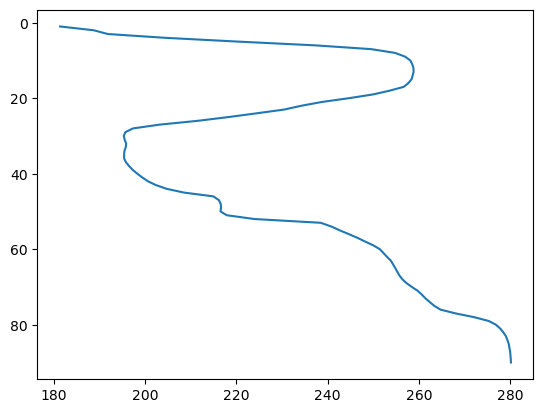

In [23]:
plt.plot(T.mean(["lat", "lon"]), T.level_full)
plt.gca().invert_yaxis()

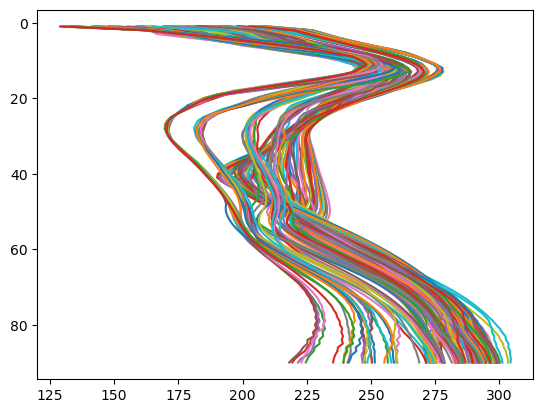

In [51]:
plt.plot(T.coarsen({"lat":150, "lon":300}).mean().data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

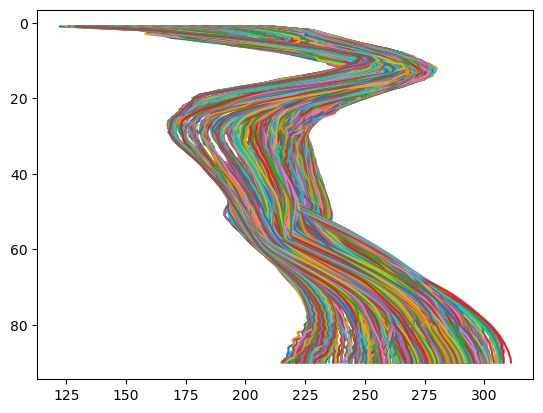

In [55]:
plt.plot(T.coarsen({"lat":50, "lon":100}).mean().data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

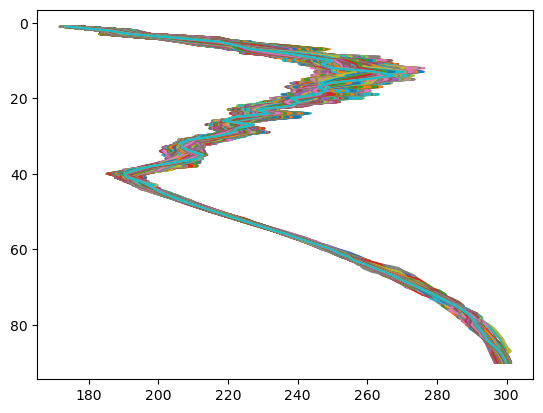

In [57]:
plt.plot(T[:,850:950,800:900].data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

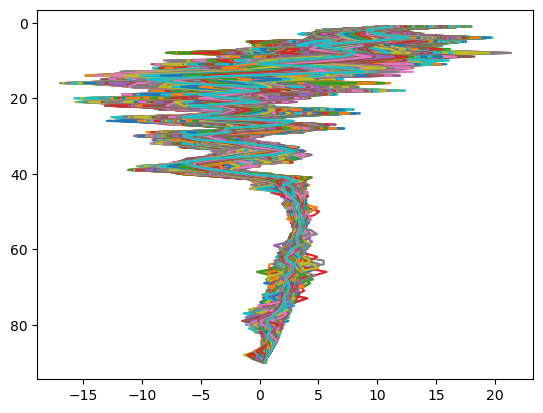

In [64]:
plt.plot(T[:,850:950,800:900].differentiate("level_full").data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

In [99]:
lowest_inversion = (T.level_full * (T[:75,:901:300,900:1200:50].differentiate("level_full") < 0)).max("level_full")
lowest_inversion

<xarray.DataArray (lat: 4, lon: 6)> Size: 96B
array([[54, 54, 54, 54, 54, 54],
       [51, 51, 52, 53, 53, 51],
       [39, 38, 38, 38, 38, 38],
       [40, 40, 39, 41, 39, 40]], dtype=int32)
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T00:15:00
  * lat      (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon      (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1

In [122]:
lowest_inversion.values

array([[54, 54, 54, 54, 54, 54],
       [51, 51, 52, 53, 53, 51],
       [39, 38, 38, 38, 38, 38],
       [40, 40, 39, 41, 39, 40]], dtype=int32)

In [148]:
T[:,:901:300,900:1200:50].sel(lat=lowest_inversion.lat, lon=lowest_inversion.lon, level_full=lowest_inversion)

<xarray.DataArray 'ta' (lat: 4, lon: 6)> Size: 96B
array([[221.18816, 221.18816, 221.18816, 221.18816, 221.18816, 221.18816],
       [217.48148, 221.13164, 221.68256, 224.45255, 223.14522, 218.01915],
       [194.62828, 194.98985, 194.22476, 196.404  , 195.19196, 196.06561],
       [188.6242 , 190.65506, 190.52711, 190.8471 , 192.6614 , 189.31969]],
      dtype=float32)
Coordinates:
    level_full  (lat, lon) int32 96B 54 54 54 54 54 54 51 ... 40 40 39 41 39 40
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon         (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

In [156]:
T[:,:901:300,900:1200:50].loc[lowest_inversion]

<xarray.DataArray 'ta' (lat: 4, lon: 6)> Size: 96B
array([[221.18816, 221.18816, 221.18816, 221.18816, 221.18816, 221.18816],
       [217.48148, 221.13164, 221.68256, 224.45255, 223.14522, 218.01915],
       [194.62828, 194.98985, 194.22476, 196.404  , 195.19196, 196.06561],
       [188.6242 , 190.65506, 190.52711, 190.8471 , 192.6614 , 189.31969]],
      dtype=float32)
Coordinates:
    level_full  (lat, lon) int32 96B 54 54 54 54 54 54 51 ... 40 40 39 41 39 40
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon         (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

In [161]:
xr.concat([lowest_inversion + i for i in range(-3,4)], dim="new_level").assign_coords({"new_level":range(-3,4)})

<xarray.DataArray (new_level: 7, lat: 4, lon: 6)> Size: 672B
array([[[51, 51, 51, 51, 51, 51],
        [48, 48, 49, 50, 50, 48],
        [36, 35, 35, 35, 35, 35],
        [37, 37, 36, 38, 36, 37]],

       [[52, 52, 52, 52, 52, 52],
        [49, 49, 50, 51, 51, 49],
        [37, 36, 36, 36, 36, 36],
        [38, 38, 37, 39, 37, 38]],

       [[53, 53, 53, 53, 53, 53],
        [50, 50, 51, 52, 52, 50],
        [38, 37, 37, 37, 37, 37],
        [39, 39, 38, 40, 38, 39]],

       [[54, 54, 54, 54, 54, 54],
        [51, 51, 52, 53, 53, 51],
        [39, 38, 38, 38, 38, 38],
        [40, 40, 39, 41, 39, 40]],

       [[55, 55, 55, 55, 55, 55],
        [52, 52, 53, 54, 54, 52],
        [40, 39, 39, 39, 39, 39],
        [41, 41, 40, 42, 40, 41]],

       [[56, 56, 56, 56, 56, 56],
        [53, 53, 54, 55, 55, 53],
        [41, 40, 40, 40, 40, 40],
        [42, 42, 41, 43, 41, 42]],

       [[57, 57, 57, 57, 57, 57],
        [54, 54, 55, 56, 56, 54],
        [42, 41, 41, 41, 41, 41],
        [43, 43, 42, 44, 42, 43]]], dtype=int32)
Coordinates:
    time       datetime64[ns] 8B 2021-07-01T00:15:00
  * lat        (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon        (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1
  * new_level  (new_level) int64 56B -3 -2 -1 0 1 2 3

In [162]:
T[:,:901:300,900:1200:50].loc[
    xr.concat([lowest_inversion + i for i in range(-3,4)], dim="new_level").assign_coords({"new_level":range(-3,4)})
]

<xarray.DataArray 'ta' (new_level: 7, lat: 4, lon: 6)> Size: 672B
array([[[229.26666, 229.26666, 229.26666, 229.26666, 229.26666,
         229.26666],
        [224.59784, 222.36284, 225.8367 , 228.1613 , 225.56728,
         222.37308],
        [199.7236 , 201.87462, 200.92102, 205.37024, 204.43874,
         205.81285],
        [211.51228, 208.03561, 209.22069, 199.83223, 203.4137 ,
         198.67412]],

       [[227.28731, 227.28731, 227.28731, 227.28731, 227.28731,
         227.28731],
        [223.40457, 221.51663, 224.08005, 226.78499, 225.55888,
         221.75723],
        [197.45634, 199.43932, 199.63187, 199.06706, 200.11136,
         201.7886 ],
        [200.83199, 201.84096, 208.22801, 194.14992, 204.3611 ,
         198.47209]],

       [[224.58736, 224.58736, 224.58736, 224.58736, 224.58736,
         224.58736],
...
        [189.20245, 190.60475, 188.58759, 191.64874, 190.3711 ,
         190.93596]],

       [[221.61267, 221.61267, 221.61267, 221.61267, 221.61267,
         221.61267],
        [220.2583 , 221.81775, 222.51726, 224.85309, 225.1945 ,
         220.88489],
        [198.32564, 196.54451, 197.31242, 197.12032, 199.59482,
         199.09401],
        [192.3815 , 192.37218, 190.71832, 194.07875, 193.07576,
         193.7994 ]],

       [[222.97307, 222.97307, 222.97307, 222.97307, 222.97307,
         222.97307],
        [224.01685, 223.47575, 225.04857, 225.68356, 228.40764,
         223.92162],
        [201.21506, 199.35764, 199.52362, 200.11024, 200.03696,
         199.81836],
        [194.63623, 195.37517, 192.10536, 197.24208, 193.78093,
         194.9921 ]]], dtype=float32)
Coordinates:
    level_full  (new_level, lat, lon) int32 672B 51 51 51 51 51 ... 42 44 42 43
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon         (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1
  * new_level   (new_level) int64 56B -3 -2 -1 0 1 2 3
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

In [163]:
T[:,:901:300,900:1200:50].loc[
    xr.concat([lowest_inversion + i for i in range(-3,4)], dim="new_level").assign_coords({"new_level":range(-3,4)})
].idxmin("new_level")

<xarray.DataArray 'new_level' (lat: 4, lon: 6)> Size: 192B
array([[1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 1., 0.]])
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T00:15:00
  * lat      (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon      (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1

In [165]:
lowest_inversion

<xarray.DataArray (lat: 4, lon: 6)> Size: 96B
array([[54, 54, 54, 54, 54, 54],
       [51, 51, 52, 53, 53, 51],
       [39, 38, 38, 38, 38, 38],
       [40, 40, 39, 41, 39, 40]], dtype=int32)
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T00:15:00
  * lat      (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon      (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1

In [166]:
trop_level = lowest_inversion + T[:,:901:300,900:1200:50].loc[
    xr.concat([lowest_inversion + i for i in range(-3,4)], dim="new_level").assign_coords({"new_level":range(-3,4)})
].idxmin("new_level")

In [167]:
trop_level

<xarray.DataArray (lat: 4, lon: 6)> Size: 192B
array([[55., 55., 55., 55., 55., 55.],
       [51., 52., 53., 54., 53., 51.],
       [40., 38., 38., 39., 38., 38.],
       [40., 41., 40., 41., 40., 40.]])
Coordinates:
    time     datetime64[ns] 8B 2021-07-01T00:15:00
  * lat      (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon      (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1

In [168]:
T[:,:901:300,900:1200:50].loc[trop_level]

<xarray.DataArray 'ta' (lat: 4, lon: 6)> Size: 96B
array([[220.58398, 220.58398, 220.58398, 220.58398, 220.58398, 220.58398],
       [217.48148, 220.51553, 221.64484, 224.00241, 223.14522, 218.01915],
       [194.18607, 194.98985, 194.22476, 195.89096, 195.19196, 196.06561],
       [188.6242 , 190.60475, 188.58759, 190.8471 , 190.3711 , 189.31969]],
      dtype=float32)
Coordinates:
    level_full  (lat, lon) int32 96B 55 55 55 55 55 55 51 ... 40 41 40 41 40 40
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 32B 89.95 59.95 29.95 -0.05
  * lon         (lon) float64 48B 90.05 95.05 100.1 105.1 110.1 115.1
Attributes:
    cell_methods:   time: point
    component:      atmo
    grid_mapping:   crs
    long_name:      Temperature
    standard_name:  air_temperature
    units:          K
    vgrid:          reference

In [174]:
def find_tropopause(T, return_trop_temp=False):
    lowest_inversion = (
        T.level_full * (T.isel(level_full=slice(0,75)).differentiate("level_full") < 0)
    ).max("level_full")
    
    trop_level = lowest_inversion + T.sel(
        level_full=xr.concat([lowest_inversion + i for i in range(-3,4)], dim="new_level").assign_coords({"new_level":range(-3,4)})
    ).idxmin("new_level")
    
    if return_trop_temp:
        return trop_level, T.sel(level_full=trop_level)
    return trop_level


In [177]:
find_tropopause(T[:,:901:100,::100], return_trop_temp=True)

(<xarray.DataArray (lat: 10, lon: 36)> Size: 3kB
 array([[55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
         55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
         55., 55., 55., 55., 55., 55., 55., 55., 55., 55.],
        [56., 55., 54., 54., 71., 52., 51., 50., 69., 70., 51., 51., 53.,
         54., 56., 57., 57., 59., 59., 63., 59., 59., 58., 58., 57., 57.,
         56., 57., 57., 56., 55., 56., 55., 55., 56., 56.],
        [56., 56., 53., 53., 54., 55., 52., 52., 54., 54., 54., 52., 50.,
         50., 52., 54., 55., 57., 56., 55., 53., 50., 48., 49., 49., 49.,
         49., 50., 51., 51., 54., 54., 54., 55., 56., 56.],
        [53., 52., 54., 54., 54., 54., 55., 55., 50., 51., 53., 53., 52.,
         51., 51., 50., 49., 50., 52., 52., 49., 51., 52., 54., 49., 49.,
         49., 51., 52., 54., 55., 53., 53., 54., 54., 56.],
        [53., 72., 50., 53., 51., 51., 52., 55., 54., 48., 52., 39., 43.,
         38., 42., 37., 47., 47., 47., 48., 4

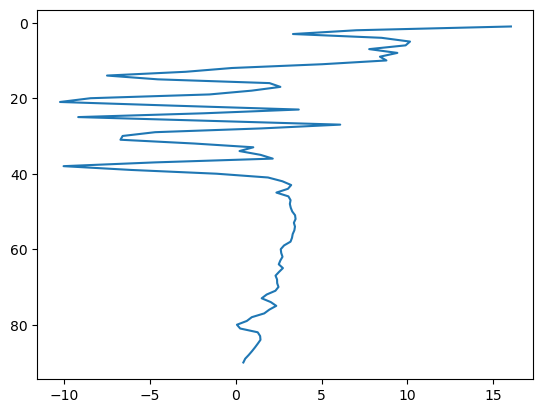

In [68]:
plt.plot(T[:,900,900].differentiate("level_full"), T.level_full)
plt.gca().invert_yaxis()

In [ ]:
plt.plot(T[:,900,900], T.level_full)
plt.gca().invert_yaxis()

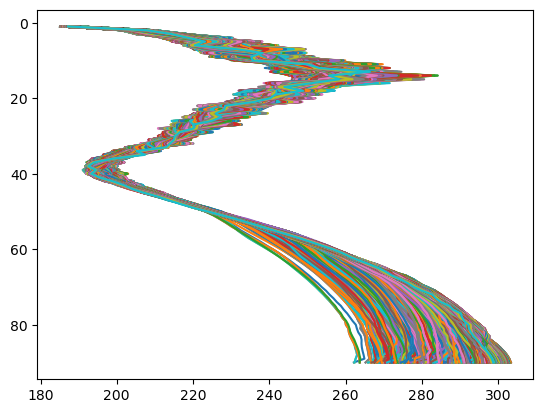

In [59]:
plt.plot(T[:,550:650,800:900].data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

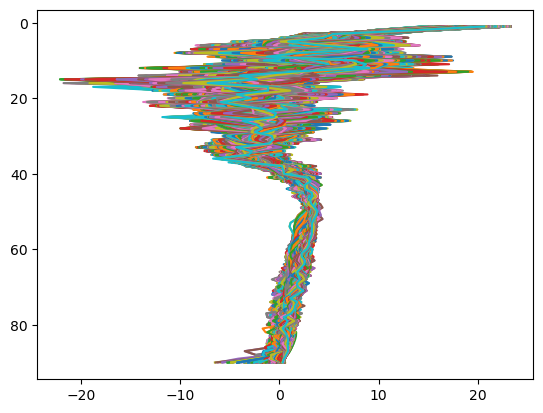

In [63]:
plt.plot(T[:,550:650,800:900].differentiate("level_full").data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

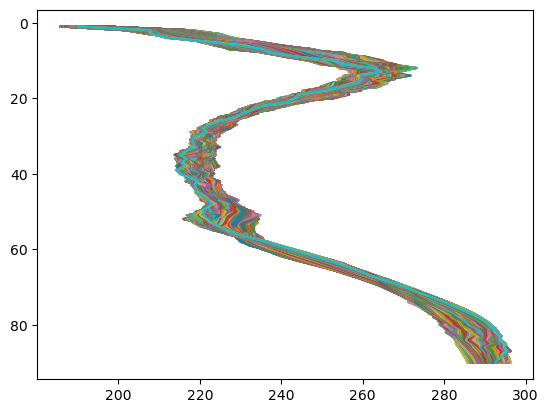

In [58]:
plt.plot(T[:,250:350,800:900].data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

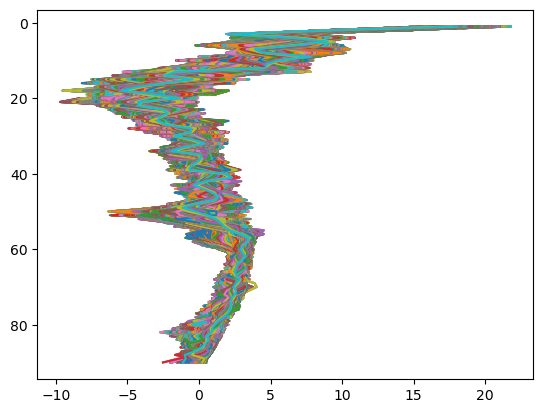

In [62]:
plt.plot(T[:,250:350,800:900].differentiate("level_full").data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

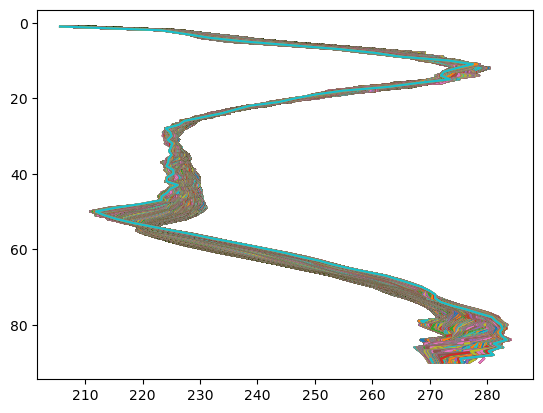

In [60]:
plt.plot(T[:,:100,800:900].data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

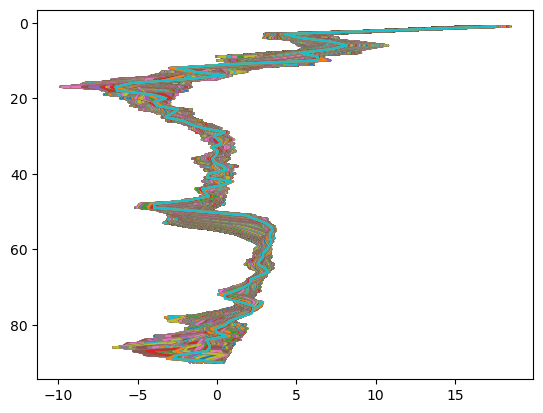

In [61]:
plt.plot(T[:,:100,800:900].differentiate("level_full").data.reshape([90,-1]), T.level_full)
plt.gca().invert_yaxis()

In [46]:
T.mean(["lon"])

<xarray.DataArray 'ta' (level_full: 90, lat: 1800)> Size: 648kB
array([[209.5655  , 209.56265 , 209.56639 , ..., 127.470184, 128.76114 ,
        128.78568 ],
       [226.51593 , 226.50143 , 226.5055  , ..., 159.23692 , 160.19275 ,
        160.77432 ],
       [231.68028 , 231.67961 , 231.68448 , ..., 176.7109  , 176.74231 ,
        176.7425  ],
       ...,
       [271.62137 , 271.53867 , 271.37836 , ..., 225.50449 , 225.09004 ,
        224.66808 ],
       [272.1799  , 272.09732 , 271.9294  , ..., 224.47705 , 224.37126 ,
        224.07085 ],
       [272.56412 , 272.46017 , 272.27774 , ..., 223.11224 , 223.39424 ,
        223.07039 ]], dtype=float32)
Coordinates:
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95

In [47]:
T.mean(["lon"]).coarsen({"lat":150}).mean()

<xarray.DataArray 'ta' (level_full: 90, lat: 12)> Size: 4kB
array([[208.06557, 201.80565, 193.27039, ..., 160.8192 , 145.56755,
        132.78847],
       [224.36398, 218.439  , 209.65585, ..., 181.77885, 169.26651,
        163.8324 ],
       [229.42493, 223.22672, 213.4506 , ..., 187.51201, 176.25075,
        177.20786],
       ...,
       [272.95718, 283.67908, 287.48834, ..., 274.77216, 255.04143,
        234.68591],
       [273.39453, 284.1112 , 287.94156, ..., 275.41367, 255.18071,
        233.7867 ],
       [273.6893 , 284.40533, 288.1789 , ..., 275.83566, 255.30641,
        233.17091]], dtype=float32)
Coordinates:
  * level_full  (level_full) int32 360B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
    time        datetime64[ns] 8B 2021-07-01T00:15:00
  * lat         (lat) float64 96B 82.5 67.5 52.5 37.5 ... -52.5 -67.5 -82.5

In [50]:
T.coarsen({"lat":150, "lon":300}).mean().shape

(90, 12, 12)

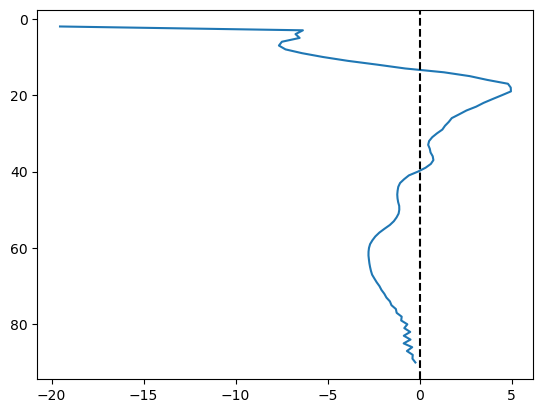

In [29]:
plt.plot(-T.diff("level_full").mean(["lat", "lon"]), T.level_full[1:])
plt.gca().invert_yaxis()
plt.gca().axvline(0, color="k", linestyle="--")

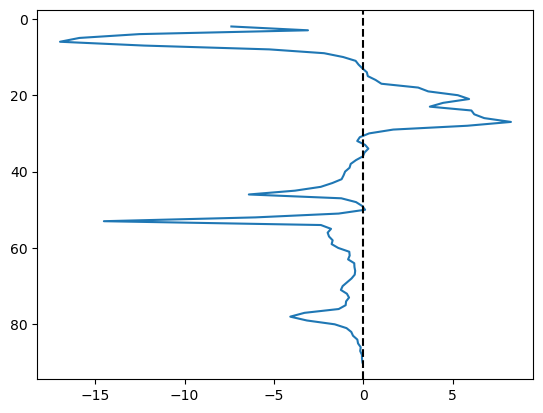

In [30]:
plt.plot(-T.mean(["lat", "lon"]).diff("level_full"), T.level_full[1:])
plt.gca().invert_yaxis()
plt.gca().axvline(0, color="k", linestyle="--")